In [1]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os, pickle
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder

from itertools import product

import sys, os

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P


num_data = 355504


np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

2023-11-29 07:21:47.167748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0.4 0.6 1. ]


# LOADING THE DATA

In [2]:
# if re_split:


aggr_df = pd.read_csv('mimic_iv_hypotensive_cut2.csv',sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()
# create action bins (four actions in total)
aggr_df['action'] = aggr_df['bolus(binary)']*2 + aggr_df['vaso(binary)']
all_idx = np.random.permutation(aggr_df.index.get_level_values(0).unique())
train_df = aggr_df.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
# print (np.unique(train_df['action'],return_counts=True)[1]*1./len(train_df))
# pickle.dump([train_df, test_df, valid_df], open(data_save_path+'processed_mimic_hyp_2.pkl','wb'))
drop_columns = ['vaso(amount)','bolus(amount)',\
            'any_treatment(binary)','vaso(binary)','bolus(binary)']




# LOOKING AT THE DATA

In [3]:
## print(len(aggr_df))
aggr_df.head()

creatinine  \
stay_id  time                                                     
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)         NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)         2.7   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)         NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)         NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)         NaN   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                       NaN   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   

                                                     lactate  urine_output  \
stay_id  time                                                                
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)      NaN           NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)      NaN          40.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)      NaN         100.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)      1.7           NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)      NaN          40.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      38.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                        NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      114.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                        NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                        NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                        NaN   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                 61.0   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                 63.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                 99.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                 72.0   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                 70.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                      56.0   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      46.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                      75.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                      55.5   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                      53.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)             

# Data for patient with hypotension, two treatment vasopressors and a bolus dose of epinephrine depending on certain features of the patient. In order to do IRL we need to discretize the action space:
* Action 0 = No treatment
* Action 1 = Vaso
* Action 2 = Bolus
* Action 3 = Vaso + Bolus



# Data cleaning for taking care of missing values

In [4]:
# for now drop indicators about bolus and vaso
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)
valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('mimic_iv_hypotensive_cut2_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')




for f in impute_table.index:
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])

# Add observational and action ambiguity

In [5]:
import suboptimality as SO

## UNCOMMENT TO ADD OBSERVATIONAL AMBIGUITY

In [6]:
suboptimal_features = ['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
                  'alanine_aminotransferase', 'asparate_aminotransferase',
                  'mean_blood_pressure', 'diastolic_blood_pressure',
                  'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen', 
                  'heart_rate', 'temperature', 'respiratory_rate']

train_df = SO.observation_ambiguity(train_df, suboptimal_features, 0.1, 0.3)
test_df = SO.observation_ambiguity(test_df, suboptimal_features, 0.1, 0.3)
valid_df = SO.observation_ambiguity(valid_df, suboptimal_features, 0.1, 0.3)

## UNCOMMENT TO ADD ACTION AMBIGUITY

In [7]:
# train_df = SO.action_ambiguity(train_df, 0.3)
# test_df = SO.action_ambiguity(test_df, 0.3)
# valid_df = SO.action_ambiguity(valid_df, 0.3)

# Normalize data

In [8]:
data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()


#### standard normalization ####
normalize_features = ['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
                  'alanine_aminotransferase', 'asparate_aminotransferase',
                  'mean_blood_pressure', 'diastolic_blood_pressure',
                  'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen']
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values
train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std




### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']

In [9]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()


In [10]:
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()
# data_df = data_df.head(num_data).copy()
# X_df = X_df.head(num_data).copy()
# y_df = y_df.head(num_data).copy()


In [11]:
print(len(data_df))
print(len(X_df))
print(len(y_df))
print(len(data_non_normalized_df))

355504
355504
355504
355504


# Normalized version of the data

In [12]:
data_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)   -0.421475   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)   -0.421475   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)   -0.289503   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)   -0.421475   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)   -0.421475   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -1.75829   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -1.75829   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -1.75829   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -1.75829   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -1.75829   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29) -0.182337     -0.225739   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29) -0.182337     -0.225739   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)  0.359987     -0.225739   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)  0.359987     -0.225739   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)  0.359987     -0.342061   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -0.278455   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -0.288263   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -0.294100   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -0.288263   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -0.288263   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -0.265147   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -0.265147   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -0.265147   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -0.265147   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -0.265147   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             0.404399   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)             0.404399   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)             0.404399   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)             0.404399   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)             0.404399   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  0.390936   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  0.390936   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  0.390936   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  0.390936   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  0.305794   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      

# Unormalized version of the data

In [13]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)    1.000000   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)    1.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)    1.193439   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)    1.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)    1.000000   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      0.21   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      0.21   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      0.21   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      0.21   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      0.21   

                                                     lactate  urine_output  \
stay_id  time                                                                
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      1.8     80.000000   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)      1.8     80.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)      3.0     80.000000   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)      3.0     80.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)      3.0     65.627978   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 40.145887   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 34.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 30.342561   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 34.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 34.000000   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                       40.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                       40.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                       40.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                       40.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 77.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 77.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 77.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 77.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 77.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 59.000000   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 59.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 59.000000   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 59.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 58.057545   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             

# Matrix form of the data (Normalized and features only)

In [14]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate
0,-0.421475,-1.75829,-0.182337,-0.225739,-0.278455,-0.265147,0.404399,0.390936,0.368307,-2.475837,-0.186180,86.000000,36.959364,19.0
1,-0.421475,-1.75829,-0.182337,-0.225739,-0.288263,-0.265147,0.404399,0.390936,0.368307,-2.671418,-0.186180,84.927928,36.998415,19.0
2,-0.289503,-1.75829,0.359987,-0.225739,-0.294100,-0.265147,0.404399,0.390936,0.385663,-2.475837,2.326179,86.000000,37.000000,19.0
3,-0.421475,-1.75829,0.359987,-0.225739,-0.288263,-0.265147,0.404399,0.390936,0.448947,-2.475837,2.353612,86.000000,36.978516,19.0
4,-0.421475,-1.75829,0.359987,-0.342061,-0.288263,-0.265147,0.404399,0.305794,0.275283,-2.475837,2.353612,80.811907,37.053451,19.0


# Corresponding output data for training BC (corresponding treatments for each data point in X_df)

In [15]:
y_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: action, dtype: float64

# Clustering the feature space to extract a discrete state space form the clusters

In [16]:
num_clusters = 100
kmeans = KMeans(n_clusters= num_clusters , random_state=0)
kmeans.fit(X_df)

KMeans(n_clusters=100, random_state=0)

In [17]:
# Looking at the values counts for each cluster

np.unique(kmeans.labels_, return_counts = True)[1]

array([9534, 5111, 7301, 3010,  861, 7047, 8068, 2736, 2668,  197,  314,
       5932, 3795,  651, 3541, 7894, 1123, 3329, 1003, 8237, 5265, 1909,
       2149, 1358, 5873, 8459, 1289, 4298, 3608, 4917, 1560, 6730,  199,
       4571, 6163,  787,  676, 4910, 2363,  391, 6625,  120, 3850, 1215,
       7341, 2960, 3228, 2567,  165, 5659,  480, 4910,  624,  544, 5914,
         16, 6697, 2236,  440, 5650, 2885, 2391, 2280, 8070, 4857, 8751,
       4707,  571, 1421, 8719, 5633, 5539, 2711, 2453, 6678,  551, 1879,
       5912,  518, 8579,    2,    6, 1100, 8366, 1791, 3822,  206, 3785,
       3704, 5815, 1496, 9247, 4433,  686, 1105, 2328,  471, 3925, 5477,
       1566])

In [18]:
# Assigning each data point to a cluster

X_df['cluster'] = kmeans.labels_.copy()
data_df['cluster'] = kmeans.labels_.copy()
data_non_normalized_df['cluster'] = kmeans.labels_.copy()

In [19]:
print(X_df['cluster'].unique())

[83 15 91 44 92 19 79 31  0 13 66 37 25 74 56 71 54 34  2 11 40 98 87 49
 47 21 88 23 64  5 48 27 60  1 17 51 97 38 24 42 45 39 57 12  8 62 99 10
  4 76 72 65 69  6 63 59 14 78 68 35 46 22 89 73 29 95 33 20 28 52 67 43
 84 61 36  7 77 30 70  3 26 58 18 16 85 86 53 41 50 93 94 32 90 75 96  9
 55 82 81 80]


In [20]:
data_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)   -0.421475   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)   -0.421475   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)   -0.289503   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)   -0.421475   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)   -0.421475   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -1.75829   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -1.75829   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -1.75829   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -1.75829   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -1.75829   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29) -0.182337     -0.225739   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29) -0.182337     -0.225739   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)  0.359987     -0.225739   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)  0.359987     -0.225739   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)  0.359987     -0.342061   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -0.278455   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -0.288263   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -0.294100   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -0.288263   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -0.288263   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -0.265147   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -0.265147   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -0.265147   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -0.265147   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -0.265147   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             0.404399   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)             0.404399   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)             0.404399   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)             0.404399   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)             0.404399   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  0.390936   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  0.390936   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  0.390936   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  0.390936   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  0.305794   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      

In [21]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,cluster
0,-0.421475,-1.75829,-0.182337,-0.225739,-0.278455,-0.265147,0.404399,0.390936,0.368307,-2.475837,-0.186180,86.000000,36.959364,19.0,83
1,-0.421475,-1.75829,-0.182337,-0.225739,-0.288263,-0.265147,0.404399,0.390936,0.368307,-2.671418,-0.186180,84.927928,36.998415,19.0,15
2,-0.289503,-1.75829,0.359987,-0.225739,-0.294100,-0.265147,0.404399,0.390936,0.385663,-2.475837,2.326179,86.000000,37.000000,19.0,83
3,-0.421475,-1.75829,0.359987,-0.225739,-0.288263,-0.265147,0.404399,0.390936,0.448947,-2.475837,2.353612,86.000000,36.978516,19.0,83
4,-0.421475,-1.75829,0.359987,-0.342061,-0.288263,-0.265147,0.404399,0.305794,0.275283,-2.475837,2.353612,80.811907,37.053451,19.0,91


In [22]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)    1.000000   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)    1.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)    1.193439   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)    1.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)    1.000000   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      0.21   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      0.21   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      0.21   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      0.21   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      0.21   

                                                     lactate  urine_output  \
stay_id  time                                                                
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      1.8     80.000000   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)      1.8     80.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)      3.0     80.000000   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)      3.0     80.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)      3.0     65.627978   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 40.145887   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 34.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 30.342561   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 34.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 34.000000   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                       40.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                       40.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                       40.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                       40.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 77.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 77.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 77.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 77.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 77.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 59.000000   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 59.000000   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 59.000000   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 59.000000   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 58.057545   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             

## Add Static and Dynamic Occlusion

## UNCOMMENT TO ADD STATIC OCCLUSION

In [29]:
# excluded_states = [2, 89, 98, 54, 71, 49, 3, 97, 10, 74, 52, 58, 99, 6, 69,
#                    9, 94, 83, 85, 47, 20, 27, 64, 19, 22, 81, 92, 5, 35, 16]
# data_df = SO.static_occlusion(data_df, excluded_states)

## UNCOMMENT TO ADD DYNAMIC OCCLUSION

In [48]:
# data_df = SO.dynamic_occlusion(data_df, 0.3) 

In [23]:
# This should be roughly 248852
print(len(data_df))

355504


In [24]:
# Should be 70 for Static occlusion and ~100 for Dynamic occlusion unless some clusters are completely taken out
print(len(data_df['cluster'].unique()))

100


# Converting the data into trajectories to input to an IRL algorithm Note this is the same format of trajectories we used for HW1 and HW2.

In [33]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()

trajectories = []


for stay_id in unique_stay_ids:


  states, actions = data_df.loc[stay_id]['cluster'], data_df.loc[stay_id]['action']

  trajectory = []
  for i in range(len(states) - 1):
    trajectory.append((states[i], int(actions[i]), states[i+1] ))

  trajectories.append(T.Trajectory(trajectory))

We need to store all possible terminal states from the trajectories list. (Needed to calculate the normalizing constant in MaxEnt)

In [34]:
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

# Distribution of the treatments given in our data. (Most of the time no treatment is given, might vary on depending on how you cluster the data)

In [35]:
y_df.value_counts()

0.0    163520
1.0    121557
3.0     38031
2.0     32396
Name: action, dtype: int64

# BC Policy example

In [36]:
# Convert states and actions to one-hot encoding
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(4)])


states_onehot = state_encoder.fit_transform(X_df['cluster'].to_numpy().reshape(-1, 1))
actions_onehot = action_encoder.fit_transform(y_df.to_numpy().reshape(-1, 1))


# # Define neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(states_onehot.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(actions_onehot.shape[1], activation='softmax')  # Output layer with softmax for discrete actions
])

# # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

# # Train the model
model.fit(states_onehot, actions_onehot,  epochs=5, batch_size=128)

# # Evaluate the model
test_loss = model.evaluate(states_onehot, actions_onehot)
print("Test Loss:", test_loss)


Epoch 1/5
2778/2778 [==============================] - 8s 2ms/step - loss: 1.1777 - accuracy: 0.4674
Epoch 2/5
2778/2778 [==============================] - 6s 2ms/step - loss: 1.1750 - accuracy: 0.4706
Epoch 3/5
2778/2778 [==============================] - 6s 2ms/step - loss: 1.1747 - accuracy: 0.4706
Epoch 4/5
2778/2778 [==============================] - 6s 2ms/step - loss: 1.1744 - accuracy: 0.4703
Epoch 5/5
11110/11110 [==============================] - 16s 1ms/step - loss: 1.1734 - accuracy: 0.4710
Test Loss: [1.1734468936920166, 0.47096797823905945]


In [37]:
bc_policy = np.argmax(model.predict(state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))), axis =1)
bc_policy

4/4 [==============================] - 0s 2ms/step


array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
# Default plot code

# fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 16))

# for i, ax in enumerate(axes.flatten()):
#     data_df[data_df['cluster'] == i]['action'].value_counts().plot(kind = 'bar', ax = ax, title = 'Cluster: ' + str(i+ 1))
#     ax.set_ylabel('Counts')
    
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 16))

labels = ['No action', 'Vaso', 'Bolus', 'Vaso + Bolus']

for i, ax in enumerate(axes.flatten()):
    print(data_df[data_df['cluster'] == i]['action'].value_counts().tolist())

for i, ax in enumerate(axes.flatten()):
    policy = data_df[data_df['cluster'] == i]['action'].value_counts().tolist()
    while len(policy) < 4:
        policy.append(0)
    ax.pie(policy, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 17})
    ax.set_title('Cluster ' + str(i+ 1), fontsize=25)

fig.suptitle("BC Policy", fontsize=50)

# Estimating the Transition Dynamics using the MLE (feel free to play around with the smoothing_value)

In [ ]:
smoothing_value = 1

p_transition = np.zeros((num_clusters, num_clusters, 4)) + smoothing_value


for traj in trajectories:

  for tran in traj._t:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [ ]:
p_transition

# Max Causal Entropy

# Feel free to play with the discount factor

In [ ]:
discount = 0.9

In [ ]:
from maxent import irl, irl_causal

In [ ]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
# reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

In [ ]:
reward_maxent_causal

In [ ]:
v = reward_maxent_causal
normalized_reward_maxent_causal = (v - v.min()) / (v.max() - v.min())
print(normalized_reward_maxent_causal)

In [ ]:
reshaped_rewards = normalized_reward_maxent_causal.reshape((10, 10))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(reshaped_rewards, cmap='inferno')
ax.set_title("MaxEnt Causal Reward Heatmap", fontsize = 20)
colorbar = fig.colorbar(im, fraction=0.046, pad=0.04)
colorbar.set_label(label = "Normalized Values", fontsize = 15)

In [ ]:
cluster_sizes = np.zeros(100)

for i in range(num_clusters):
    cluster_sizes[i] = (len(X_df.loc[X_df['cluster'] == i]))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(cluster_sizes, normalized_reward_maxent_causal)
ax.set_title("Reward Value vs. Number of Data Points per Cluster", fontsize=18)
ax.set_xlabel("Number of Data Points", fontsize = 15)
ax.set_ylabel("Normalized Reward Values", fontsize = 15)


current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

# GAIL CODE

-need to add mimic.py and transition_mat to gymnasium local installation to run this env

-assumes that trajectories are saved in variable 'trajectories' (I used the same format as above)

In [ ]:
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# from imitation.data.wrappers import RolloutInfoWrapper

# #SEED = 42

# #need to add mimic.py and transition_mat to gymnasium local installation to use this env!!!
# env = make_vec_env(
#     "mimic-v0",
#     rng=np.random.default_rng(SEED),
#     n_envs=8,
#     post_wrappers=[
#         lambda env, _: RolloutInfoWrapper(env)
#     ],
# )

# from imitation.data.types import Trajectory
# import pickle

# #with open("mimic-trajectories","rb") as f:
# #    trajectories = pickle.load(f)

# rollouts = []
# #turn trajectories into (state,action) pairs
# for gail_trajectory in trajectories:
#     obs = np.array(list(gail_trajectory.states()))
#     acts = np.array([i for (_,i,_) in gail_trajectory.transitions()])
#     rollouts.append(Trajectory(obs=obs, acts=acts, infos=None, terminal=True))

# from imitation.algorithms.adversarial.gail import GAIL
# from imitation.rewards.reward_nets import BasicRewardNet
# from imitation.util.networks import RunningNorm
# from stable_baselines3 import PPO
# from stable_baselines3.ppo import MlpPolicy
# from stable_baselines3.common.evaluation import evaluate_policy

# # This is a learner that uses the proximal policy optimization algorithm and we will it use to compute the policy update steps of the GAIL algorithm
# learner = PPO(
#     env=env,
#     policy=MlpPolicy,
#     batch_size=64,
#     ent_coef=0.0,
#     learning_rate=0.0004,
#     gamma=0.95,
#     n_epochs=5,
#     seed=SEED,
# )

# # This is a neural network that takes a batch of (state, action, next_state) triples and calculates the associated rewards and we will use it to compute the discriminator update steps of the GAIL algorithm
# reward_net = BasicRewardNet(
#     observation_space=env.observation_space,
#     action_space=env.action_space,
#     normalize_input_layer=RunningNorm,
# )

# # imitation implementation of GAIL 
# gail_trainer = GAIL(
#     demonstrations=rollouts,
#     demo_batch_size=1024,
#     gen_replay_buffer_capacity=512,
#     n_disc_updates_per_round=8,
#     venv=env,
#     gen_algo=learner,
#     reward_net=reward_net,
# )

# #this takes a while, can run it for fewer iterations
# gail_trainer.train(800_000)

# #extract policy
# GAIL_policy = [learner.predict(i,deterministic=True)[0].item() for i in range(100)]

## Gail Policies

In [32]:
# baseline policy = [0, 3, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 3, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 3, 2, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 3, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0]

# static policy = [0, 3, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 0, 0, 3, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 0, 3, 1, 0, 1, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 3, 3, 0, 0, 0, 2, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 2, 3, 3]

# dynamic policy = [0, 3, 1, 0, 1, 0, 0, 0, 3, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0]

observation_policy = [0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 
                      0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 
                      1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 3, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 
                      0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 1, 0]

action_policy = [3, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 3, 1, 0, 1, 1, 3, 3, 1, 0, 0, 1, 1, 0, 2, 0, 
                 1, 0, 1, 0, 2, 1, 1, 0, 1, 0, 3, 0, 1, 0, 3, 3, 0, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0, 
                 3, 3, 3, 1, 2, 0, 0, 1, 0, 3, 0, 0, 1, 0, 2, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 
                 1, 0, 1, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0]

# Computing the policy induced by your learnt reward

In [ ]:
V, Q = S.value_iteration(p_transition, reward_maxent_causal, discount)

In [ ]:
Q = Q.reshape((4, num_clusters))

In [ ]:
soft_pi_mce = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T

In [ ]:
soft_pi_mce

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(32, 16))

labels = ['No action', 'Vaso', 'Bolus', 'Vaso + Bolus']

for i, ax in enumerate(axes.flatten()):
    ax.pie(soft_pi_mce[i], labels=labels, autopct='%1.1f%%', textprops={'fontsize': 17})
    ax.set_title('Cluster ' + str(i+ 1), fontsize=25)

fig.suptitle("MCE Policy", fontsize=50)

In [ ]:
policy_mce = np.argmax(Q, axis = 0).reshape(-1, )

In [ ]:
policy_mce

# Identify top and bottom 5 reward clusters

In [ ]:
k = 5

min_sorted = np.sort(reward_maxent_causal)
min_five = min_sorted[:k]
min_five_indices = []

for j in range(len(min_five)):
    for i in range(len(reward_maxent_causal)):
        if min_five[j] == reward_maxent_causal[i]:
            min_five_indices.append(i)

print(min_five)
print(min_five_indices)

In [ ]:
max_sorted = np.sort(reward_maxent_causal)
max_five = max_sorted[-k:]
max_five_indices = []

for j in range(len(max_five)):
    for i in range(len(reward_maxent_causal)):
        if max_five[j] == reward_maxent_causal[i]:
            max_five_indices.append(i)

print(max_five)
print(max_five_indices)

In [ ]:
min_five_indices = np.flip(min_five_indices)
max_five_indices = np.flip(max_five_indices)
print(max_five_indices)
print(min_five_indices)

# Average values for heat map

In [26]:
viz_df = data_non_normalized_df
viz_df = viz_df.drop(['action'], axis=1)

color_matrix_y_labels = viz_df.drop(['cluster'], axis=1).columns.tolist()
# color_matrix_x_labels = max_five_indices.tolist()
# for i in min_five_indices :
#     color_matrix_x_labels.append(i)
color_matrix_x_labels = [78, 12, 67, 95, 35, 57, 62, 21, 49, 70]
print(color_matrix_y_labels)
print(color_matrix_x_labels)


color_matrix = []

# for i in max_five_indices:
#     df = viz_df[viz_df['cluster'] == i].mean()
#     lst = df.drop(['cluster']).tolist()
#     color_matrix.append(lst)    
    
# for i in min_five_indices:
#     df = viz_df[viz_df['cluster'] == i].mean()
#     lst = df.drop(['cluster']).tolist()
#     color_matrix.append(lst)
    
for i in color_matrix_x_labels:
    df = viz_df[viz_df['cluster'] == i].mean()
    lst = df.drop(['cluster']).tolist()
    color_matrix.append(lst)
    
color_matrix = np.transpose(color_matrix)

color_matrix

['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output', 'alanine_aminotransferase', 'asparate_aminotransferase', 'mean_blood_pressure', 'diastolic_blood_pressure', 'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen', 'heart_rate', 'temperature', 'respiratory_rate']
[78, 12, 67, 95, 35, 57, 62, 21, 49, 70]


array([[1.83992912e+00, 1.59633494e+00, 1.99720344e+00, 1.91133315e+00,
        1.76186627e+00, 2.05897309e+00, 1.66627369e+00, 1.90004969e+00,
        1.66597312e+00, 1.58459589e+00],
       [5.15267395e-01, 4.82870371e-01, 6.16067080e-01, 5.10207607e-01,
        5.13107293e-01, 6.03728550e-01, 4.98981078e-01, 5.82637480e-01,
        5.04785799e-01, 4.76527201e-01],
       [4.02340041e+00, 1.99196554e+00, 4.56018155e+00, 2.27148391e+00,
        2.29493331e+00, 4.34831639e+00, 2.48469403e+00, 3.38648759e+00,
        2.20589840e+00, 1.83212563e+00],
       [8.57138678e+01, 1.01193718e+02, 1.02811904e+02, 8.55470565e+01,
        9.58326405e+01, 8.32417708e+01, 1.17835912e+02, 9.16637919e+01,
        1.07279577e+02, 1.09844655e+02],
       [2.87166335e+02, 1.58640234e+02, 3.81552495e+02, 2.10676618e+02,
        1.71072042e+02, 3.14408767e+02, 2.09161126e+02, 1.79224321e+02,
        1.72816796e+02, 1.75885704e+02],
       [5.46833435e+02, 2.96873622e+02, 7.40919580e+02, 4.10293639e+02,
   

# Adding policy actions to heat map

In [33]:
bc_action = [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
# for i in color_matrix_x_labels:
#     bc_action.append(bc_policy[i])

print(bc_action)

mce_action = [1, 0, 0, 1, 0, 0, 2, 2, 1, 0]
# for i in color_matrix_x_labels:
#     mce_action.append(policy_mce[i])

print(mce_action)

gail_action = []
for i in color_matrix_x_labels:
    gail_action.append(observation_policy[i])

print(gail_action)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
[1, 0, 0, 1, 0, 0, 2, 2, 1, 0]
[0, 0, 1, 2, 1, 0, 0, 1, 0, 0]


In [34]:
color_matrix = color_matrix.tolist()

In [35]:
color_matrix.append(bc_action)
color_matrix.append(mce_action)
color_matrix.append(gail_action)

In [36]:
len(color_matrix)

17

In [37]:
color_matrix_y_labels.append('bc_action')
color_matrix_y_labels.append('mce_action')
color_matrix_y_labels.append('gail_action')

In [38]:
color_matrix_y_labels

['creatinine',
 'fraction_inspired_oxygen',
 'lactate',
 'urine_output',
 'alanine_aminotransferase',
 'asparate_aminotransferase',
 'mean_blood_pressure',
 'diastolic_blood_pressure',
 'systolic_blood_pressure',
 'gcs',
 'partial_pressure_of_oxygen',
 'heart_rate',
 'temperature',
 'respiratory_rate',
 'bc_action',
 'mce_action',
 'gail_action']

In [39]:
len(color_matrix_y_labels)
print(color_matrix_y_labels)

['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output', 'alanine_aminotransferase', 'asparate_aminotransferase', 'mean_blood_pressure', 'diastolic_blood_pressure', 'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen', 'heart_rate', 'temperature', 'respiratory_rate', 'bc_action', 'mce_action', 'gail_action']


In [40]:
normalized_color_matrix = color_matrix

for i in range(len(normalized_color_matrix)):
    lst = normalized_color_matrix[i]
    max_val = max(lst)
    min_val = min(lst)
    if color_matrix_y_labels[i] == 'bc_action' or color_matrix_y_labels[i] == 'mce_action' or color_matrix_y_labels[i] == 'gail_action':
        max_val = 3
        min_val = 0
    dif = max_val - min_val
    for j in range(len(lst)):
        normalized_color_matrix[i][j] = normalized_color_matrix[i][j]-min_val
        normalized_color_matrix[i][j] = normalized_color_matrix[i][j]/dif        

In [41]:
normalized_color_matrix

[[0.5382493804769438,
  0.024746234768472535,
  0.8697879088395982,
  0.6887710125012935,
  0.37369076836179643,
  1.0,
  0.1721790236001855,
  0.6649851675075028,
  0.17154540464316148,
  0.0],
 [0.2776281163106402,
  0.045457757533502806,
  1.0,
  0.24136760342787864,
  0.2621479445895969,
  0.9115770348701758,
  0.16091369326862157,
  0.7604297810326115,
  0.20251270408466218,
  0.0],
 [0.8032367533355278,
  0.05859114353691562,
  1.0,
  0.16105178828345595,
  0.16964743071889812,
  0.9223384070053507,
  0.23920638943345307,
  0.5697690957078756,
  0.13701067046231188,
  0.0],
 [0.07145998883815409,
  0.5189302683262395,
  0.5657065942850731,
  0.06663803794944721,
  0.3639595998833367,
  0.0,
  1.0,
  0.24345223904895005,
  0.6948519448232466,
  0.7689997024921629],
 [0.5765770804016153,
  0.0,
  1.0,
  0.2334388601122709,
  0.05576995834273783,
  0.6987885376770014,
  0.22664025331458187,
  0.09234165204497032,
  0.06359704974634169,
  0.07736438234256388],
 [0.5686279133257411,
 

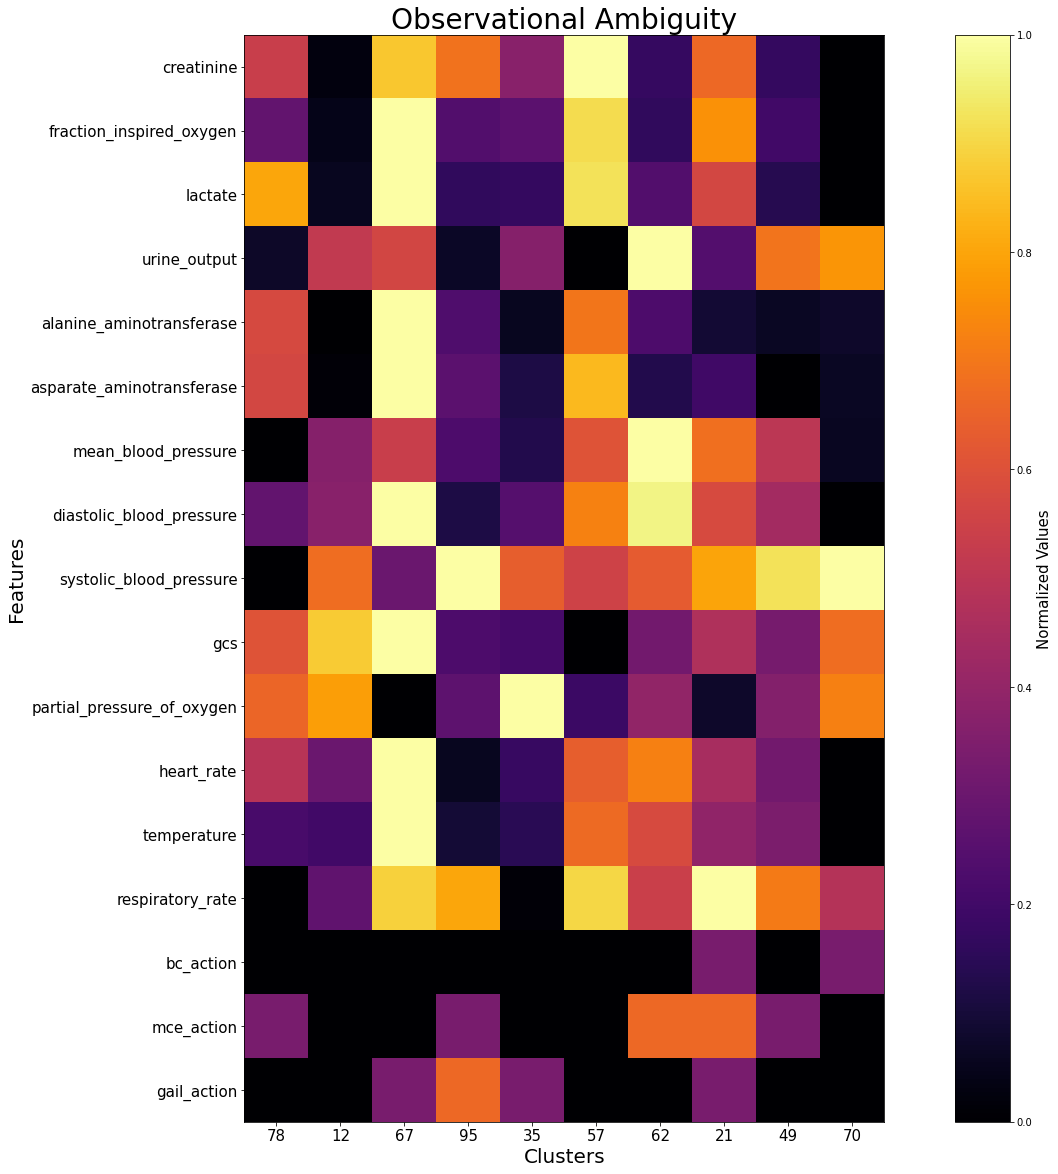

In [43]:
fig, ax = plt.subplots(figsize=(32,20))
im = ax.imshow(color_matrix, cmap='inferno')
ax.set_title("Observational Ambiguity", fontsize = 28)
ax.set_yticks(np.arange(0, 17, 1))
ax.set_yticklabels(color_matrix_y_labels, fontsize = 15)
ax.set_xticks(np.arange(0, 10, 1))
ax.set_xticklabels(color_matrix_x_labels, fontsize = 15)
ax.set_ylabel('Features', fontsize = 20)
ax.set_xlabel('Clusters', fontsize = 20)
colorbar = fig.colorbar(im, fraction=0.046, pad=0.04)
colorbar.set_label(label = "Normalized Values", fontsize = 15)